# Gemma - 2B Prompt Engineering

In [1]:
import pandas as pd

In [ ]:
!pip install rouge
!pip install evaluate

In [ ]:
# Specify the model name
model_name = "google/gemma-2b"

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


In [7]:
test_dataset_prompt_analysis = pd.read_csv('/content/test_dataset_prompt_engg.csv', encoding='ISO-8859-1')


In [11]:
print(len(test_dataset_prompt_analysis))

1001


In [ ]:
questions = test_dataset['question'].head(1000).tolist()
contexts = test_dataset['context'].head(1000).tolist()

prompts = [
    f"You are a SQL expert. Generate SQL query considering the question(in natural language) and context(schema of the database). Strictly stop after generating the query.\nQuestion: {q}\nContext: {c}\nSQL Query:"
    for q, c in zip(questions, contexts)
]

print(len(prompts))

In [ ]:
import torch
import pandas as pd

extracted_queries = []
batch_size = 5
num_batches = len(prompts) // batch_size + (0 if len(prompts) % batch_size == 0 else 1)

for i in range(num_batches):
    batch_prompts = prompts[i * batch_size:(i + 1) * batch_size]
    input_ids = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = model.generate(**input_ids, max_length=256, temperature=0)

    for output in outputs:
        answer = tokenizer.decode(output, skip_special_tokens=True)
        pattern = r"SQL Query:\s*(.*)"
        extracted_query = re.search(pattern, answer)
        if extracted_query:
            extracted_queries.append(extracted_query.group(1))
            print(extracted_query.group(1))
        else:
            extracted_queries.append("Query not found")

    # Free up memory after processing each batch
    del input_ids
    del outputs
    torch.cuda.empty_cache()

# Add the extracted queries to the DataFrame
test_dataset.loc[test_dataset.head(len(extracted_queries)).index, 'gemma_query'] = extracted_queries


In [6]:
from rouge import Rouge
from evaluate import load

In [15]:
rouge = Rouge()
metric = load("bleu")

for i in range(len(test_dataset_prompt_analysis)):
    record = test_dataset_prompt_analysis.iloc[i]
    hypothesis = record['gemma_output']
    reference = record['answer']

    # Ensure both hypothesis and reference are strings.
    if not isinstance(hypothesis, str) or not isinstance(reference, str):
        print(f"Skipping index {i} due to type mismatch.")
        continue

    scores = rouge.get_scores(hypothesis, reference, avg=False)
    test_dataset_prompt_analysis.at[i, 'rouge1'] = scores[0]['rouge-1']['f']
    test_dataset_prompt_analysis.at[i, 'rouge2'] = scores[0]['rouge-2']['f']
    test_dataset_prompt_analysis.at[i, 'rougeL'] = scores[0]['rouge-l']['f']
    test_dataset_prompt_analysis.at[i, 'exact_match'] = int(hypothesis == reference)
    test_dataset_prompt_analysis.at[i, 'bleu_score'] = metric.compute(predictions=[hypothesis], references=[[reference]])['bleu']

# Display the first few rows to check the results
print(test_dataset_prompt_analysis.head())

# Save the DataFrame to a CSV file
test_dataset_prompt_analysis.to_csv('test_dataset_prompt_analysis.csv', index=False)

Skipping index 2 due to type mismatch.
Skipping index 25 due to type mismatch.
Skipping index 46 due to type mismatch.
Skipping index 215 due to type mismatch.
Skipping index 269 due to type mismatch.
Skipping index 433 due to type mismatch.
Skipping index 461 due to type mismatch.
Skipping index 462 due to type mismatch.
Skipping index 491 due to type mismatch.
Skipping index 674 due to type mismatch.
Skipping index 721 due to type mismatch.
Skipping index 821 due to type mismatch.
Skipping index 855 due to type mismatch.
Skipping index 868 due to type mismatch.
Skipping index 896 due to type mismatch.
Skipping index 914 due to type mismatch.
Skipping index 925 due to type mismatch.
Skipping index 1000 due to type mismatch.
                                              answer  \
0  SELECT MIN(laps) FROM table_name_8 WHERE grid ...   
1  SELECT senior_status FROM table_name_18 WHERE ...   
2  SELECT MAX(rank) FROM table_name_98 WHERE reac...   
3  SELECT narrated_by FROM table_26168687

In [16]:

# Calculate the average of each score column
average_rouge1 = test_dataset_prompt_analysis['rouge1'].mean()
average_rouge2 = test_dataset_prompt_analysis['rouge2'].mean()
average_rougeL = test_dataset_prompt_analysis['rougeL'].mean()
average_exact_match = test_dataset_prompt_analysis['exact_match'].mean()
average_bleu_score = test_dataset_prompt_analysis['bleu_score'].mean()

# Print the average scores
print(f'Average Rouge-1: {average_rouge1}')
print(f'Average Rouge-2: {average_rouge2}')
print(f'Average Rouge-L: {average_rougeL}')
print(f'Average Exact Match: {average_exact_match}')
print(f'Average BLEU Score: {average_bleu_score}')


Average Rouge-1: 0.6645551622505645
Average Rouge-2: 0.4784923049077917
Average Rouge-L: 0.634790137322244
Average Exact Match: 0.003051881993896236
Average BLEU Score: 0.5145147051114702


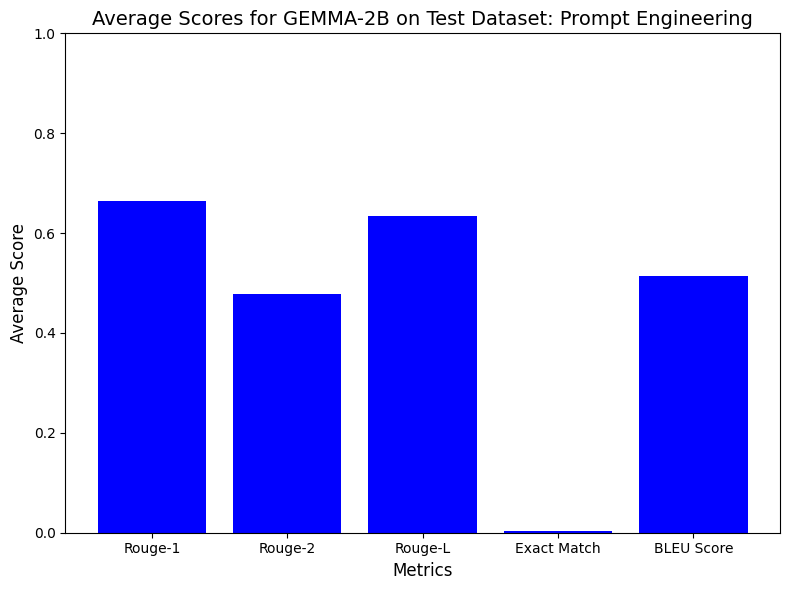

<Figure size 640x480 with 0 Axes>

In [18]:
# prompt: can you generate visualization for above average scores

import matplotlib.pyplot as plt

# Prepare data
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Exact Match', 'BLEU Score']
average_scores = [average_rouge1, average_rouge2, average_rougeL, average_exact_match, average_bleu_score]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, average_scores, color='blue')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.title('Average Scores for GEMMA-2B on Test Dataset: Prompt Engineering', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()

# Display the plot
plt.show()

# Save the plot as an image
plt.savefig('average_scores_gemma2b_head1000.png')
